In [2]:
library("ggplot2")
library("dplyr")
library("stringr")

mu_se <- function(x) {
  m <- mean(x)
  ymin <- m-sd(x)/sqrt(sum(!is.na(x)))
  ymax <- m+sd(x)/sqrt(sum(!is.na(x)))
  return(c(y=m,ymin=ymin,ymax=ymax))
}



In [3]:
tab = read.table("/Users/shayecarver/Downloads/Heritability/Morabito_RNA_ATAC_heritability.ALL_2023.clean.tab",as.is=T,sep='\t')
colnames(tab) = c("Annotation","Enrichment","se","P_value","Z_score")
tab = tab[grepl("PGCALZ2",tab[,1]),]
tab = tab[grepl("DEGs_MG",tab[,1]),]
tab$adj_p = p.adjust( tab$P_value , method="BH" )
pval_SEG_MG = -log10(min(tab$adj_p) )
pval_SEG_MG

[1] 1.994985

In [5]:
tab = read.table("/Users/shayecarver/Downloads/Heritability/Morabito_RNA_ATAC_heritability.ALL_2023.clean.tab",as.is=T,sep='\t')
colnames(tab) = c("Annotation","Enrichment","se","P_value","Z_score")

# remove 100
tab = tab[!grepl("bot100",tab[,1]),]
tab = tab[!grepl("top100",tab[,1]),]
tab = tab[!grepl("allgenes",tab[,1]),]
tab = tab[!grepl("cluster",tab[,1]),]
tab = tab[grepl("PGCALZ2",tab[,1]),]
tab = tab[grepl("ATAC",tab[,1]),]
#tab = tab[grepl("vargenes",tab[,1]),] # also allgenes
method = tab[,1] 

method[ grep("scale_ATAC_ALL_3k_vargenes",method) ] = "Standard"
method[ grep("ATAC_celltype_3kgenes",method) ] = "Conditional"

method[ grep("MG",method) ] = "MG"
method[ grep("ODC",method) ] = "ODC"
method[ grep("PER.END",method) ] = "PER.END"
method[ grep("ASC",method) ] = "ASC"
method[ grep("INH",method) ] = "INH"
method[ grep("OPC",method) ] = "OPC"
method[ grep("EX",method) ] = "EX"

tab$method = method
tab$NLP = -log10(tab$P_value)

# assign PC group
pc_group = rep(NA,nrow(tab))
for ( i in 1:5 ) {
  start = ((i-1)*10)+1
  end = start+9
  name = paste("PC",start,"-",end,sep='')
  for ( pc in start:end ) {
    pc_group[ grep( paste("PC",pc,".",sep=''),tab[,1],fixed=T ) ] = name
  }
}
tab$pc_group = pc_group

# annotate PC value
tab$PC = str_extract_all(tab$Annotation, "PC[0-9]+")

# compute method-specific q-values
tab$Q_value = NA
for ( i in unique(tab$method) ) {
  keep = (tab$method == i)
  tab$Q_value[ keep ] = p.adjust( tab$P_value[keep] , method="BH" )
}
tab$Significant = tab$Q_value < 0.05 & tab$Enrichment > 1

tab = tab[tab$Significant == TRUE,]

tab$data_type = "ATAC"

ATAC = tab

In [7]:
tab = read.table("/Users/shayecarver/Downloads/Heritability/Morabito_RNA_ATAC_heritability.ALL_2023.clean.tab",as.is=T,sep='\t')
colnames(tab) = c("Annotation","Enrichment","se","P_value","Z_score")

# remove 100
tab = tab[!grepl("bot100",tab[,1]),]
tab = tab[!grepl("top100",tab[,1]),]
tab = tab[!grepl("allgenes",tab[,1]),]
tab = tab[!grepl("cluster",tab[,1]),]
tab = tab[grepl("PGCALZ2",tab[,1]),]
tab = tab[!grepl("ATAC",tab[,1]),]
#tab = tab[grepl("vargenes",tab[,1]),] # also allgenes
method = tab[,1] 
method[ grep("MG",method) ] = "MG"
method[ grep("EX",method) ] = "EX"
method[ grep("ODC",method) ] = "ODC"
method[ grep("PER.END",method) ] = "PER.END"
method[ grep("ASC",method) ] = "ASC"
method[ grep("INH",method) ] = "INH"
method[ grep("OPC",method) ] = "OPC"
method[ grep("Conditional",method) ] = "Conditional"
method[ grep("Morabito_Regressed_batch_PCA_3kVargenes",method) ] = "Standard"
method[ grep("batch_regressed_RNA_log_scale_min.cells200",method) ] = NA

tab$method = method
tab = na.omit(tab)
tab$NLP = -log10(tab$P_value)

# assign PC group
pc_group = rep(NA,nrow(tab))
for ( i in 1:5 ) {
  start = ((i-1)*10)+1
  end = start+9
  name = paste("PC",start,"-",end,sep='')
  for ( pc in start:end ) {
    pc_group[ grep( paste("PC",pc,".",sep=''),tab[,1],fixed=T ) ] = name
  }
}
tab$pc_group = pc_group

# annotate PC value
tab$PC = str_extract_all(tab$Annotation, "PC[0-9]+")

# compute method-specific q-values
tab$Q_value = NA
for ( i in unique(tab$method) ) {
  keep = (tab$method == i)
  tab$Q_value[ keep ] = p.adjust( tab$P_value[keep] , method="BH" )
}
tab$Significant = tab$Q_value < 0.05 & tab$Enrichment > 1

tab = tab[tab$Significant == TRUE,]

tab$data_type = "RNA"

RNA = tab

In [8]:
all = rbind(ATAC, RNA)

In [88]:
total_counts = all %>% 
  group_by(method, data_type) %>% 
  summarise(n = n())

order_method = arrange(total_counts[total_counts$data_type == "ATAC",],n )$method
order_method

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.


[1] "MG"          "ASC"         "ODC"         "PER.END"     "Standard"   
[6] "OPC"         "Conditional" "INH"         "EX"

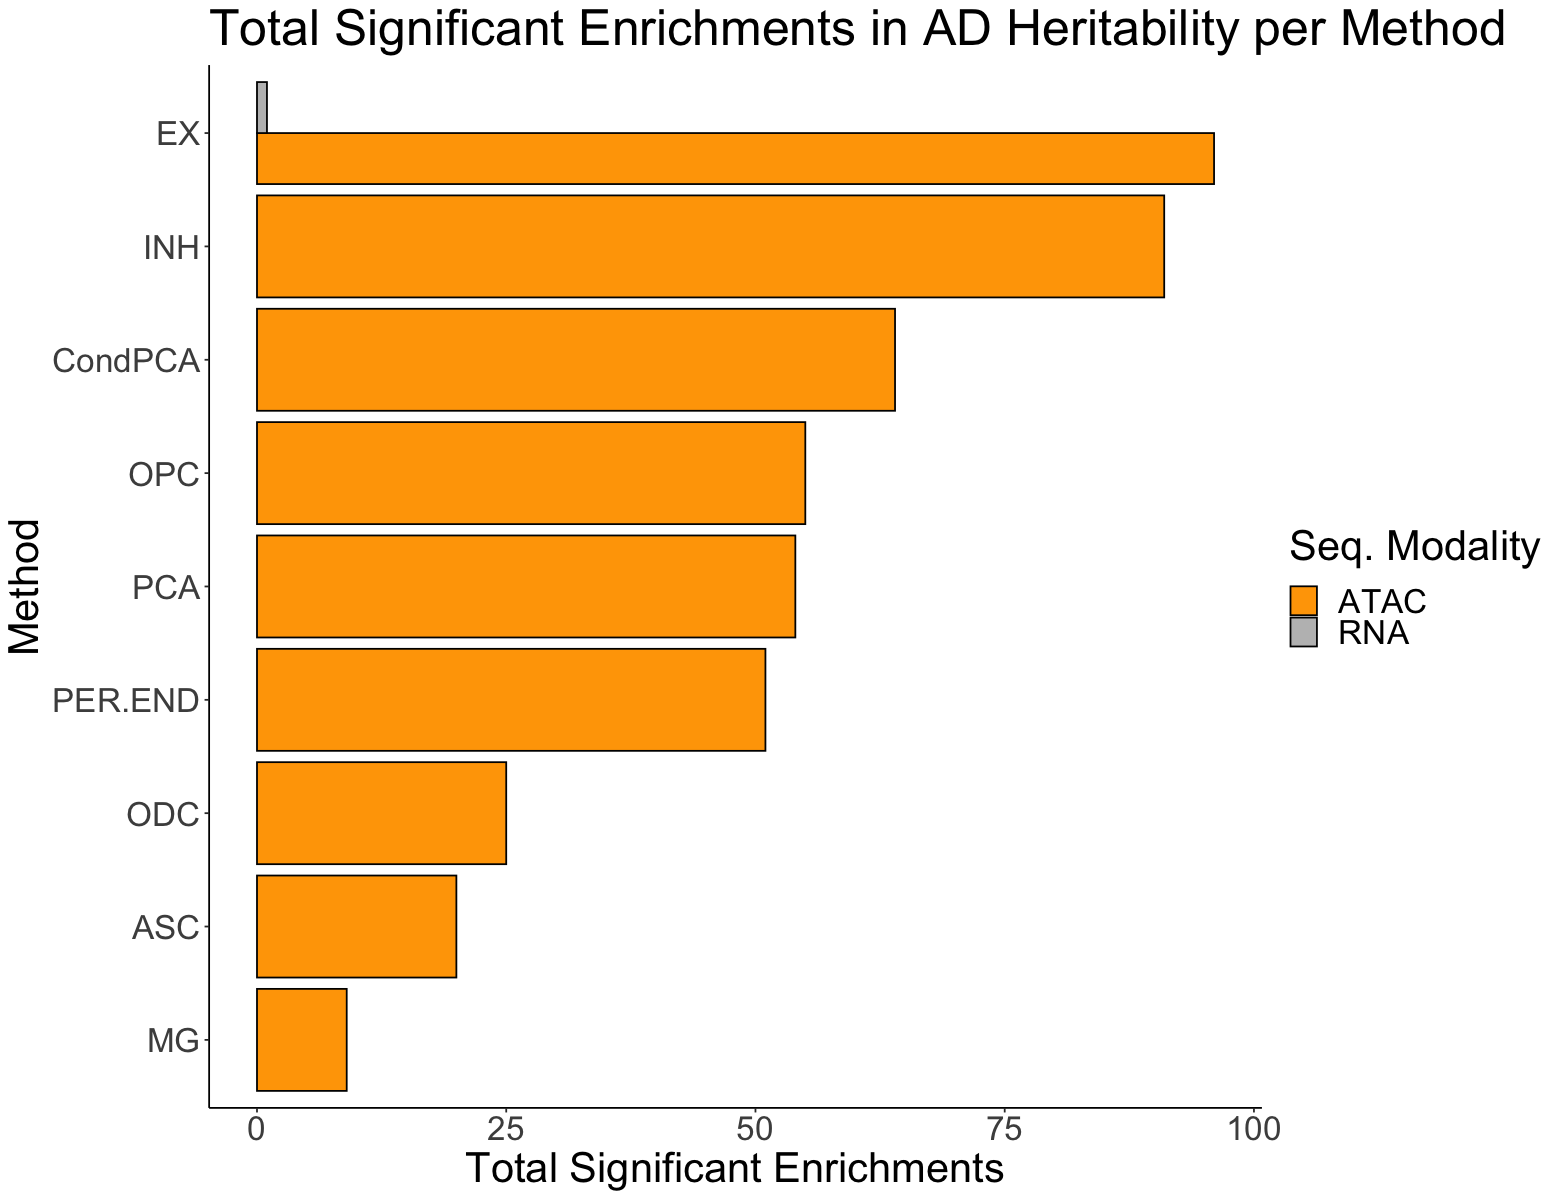

In [178]:

total_counts[total_counts$method == "Conditional",]$method = "CondPCA"
total_counts[total_counts$method == "Standard",]$method = "PCA"

total_counts$method = factor(total_counts$method, levels = total_counts[total_counts$data_type == "ATAC",][order(total_counts[total_counts$data_type == "ATAC",]$n),]$method )

options(repr.plot.width = 13, repr.plot.height = 10)
ggplot(total_counts,                                      # Grouped barplot using ggplot2
       aes(x = method,
           y = n,
           fill = data_type) ) +
  geom_bar(stat = "identity",color="black",
           position = "dodge")+theme_bw()+coord_flip()+ labs(y = "Total Significant Enrichments", x = "Method") + ggtitle('Total Significant Enrichments in AD Heritability per Method') + theme_classic()+ guides(fill=guide_legend(title="Seq. Modality"))+ theme(text = element_text(size=25,color = "black")) +scale_fill_manual(values=c("Orange", "Gray")) 
#ggsave("heritability_counts.pdf",width=10, height=10)

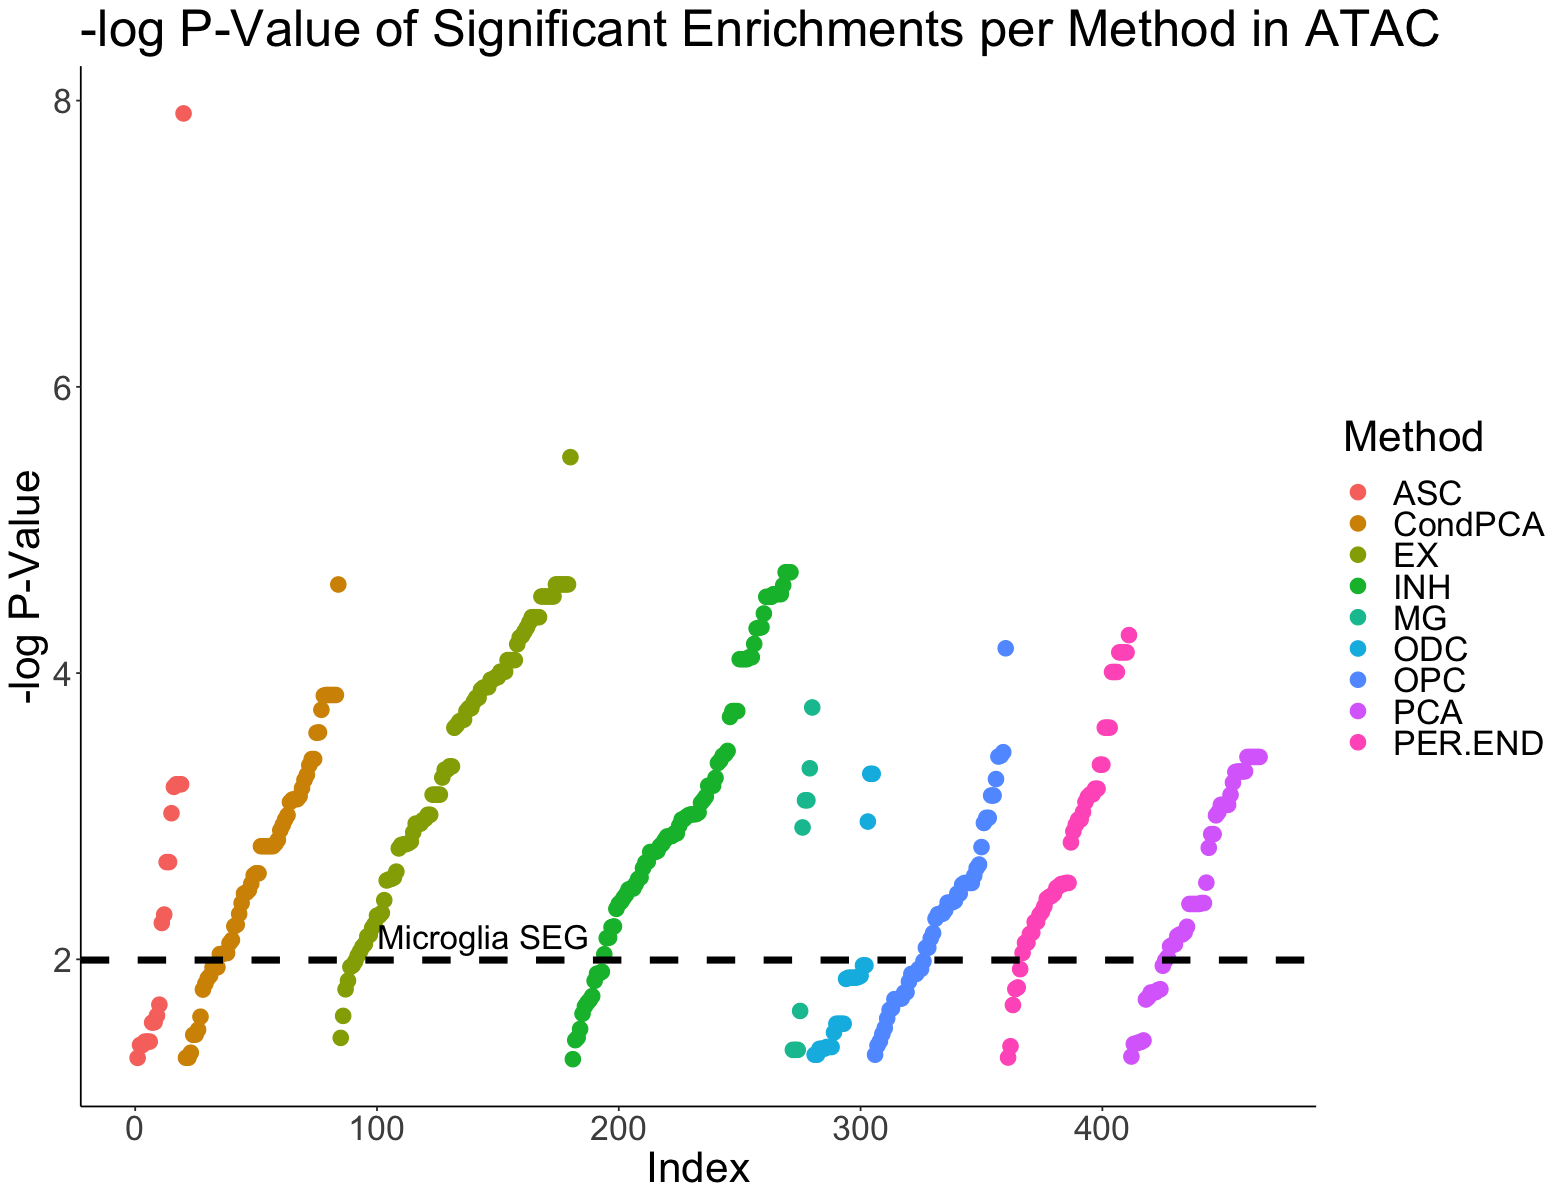

In [176]:
options(repr.plot.width = 13, repr.plot.height = 10)

ordered = all[all$data_type == "ATAC",]
ordered = ordered %>%
  group_by(method, data_type) %>%
  arrange(desc(Q_value), .by_group=TRUE)

ordered["ord"] = 1:dim(ordered)[1]
ordered["-log10pval"] = -log10(ordered$Q_value)


ordered[ordered$method == "Conditional",]$method = "CondPCA"
ordered[ordered$method == "Standard",]$method = "PCA"
ggplot(ordered, aes(x=ord, y=`-log10pval`,color = method)) + geom_point(size=4) + geom_jitter() + labs(y = "-log P-Value", x = "Index")+ ggtitle('-log P-Value of Significant Enrichments per Method in ATAC')+ theme_classic() + scale_color_discrete(name = "Method")+ theme(text = element_text(size=25.5))+
  geom_hline(yintercept=pval_SEG_MG,linetype="dashed", size=2) +
  annotate("text", x=100, y=pval_SEG_MG, label= "Microglia SEG" , hjust=0, vjust=-0.5,size=7)+ guides(fill=guide_legend(title="Method"))
#ggsave("pval_plot_heritability_enrichments.pdf",width=10, height=10)

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.


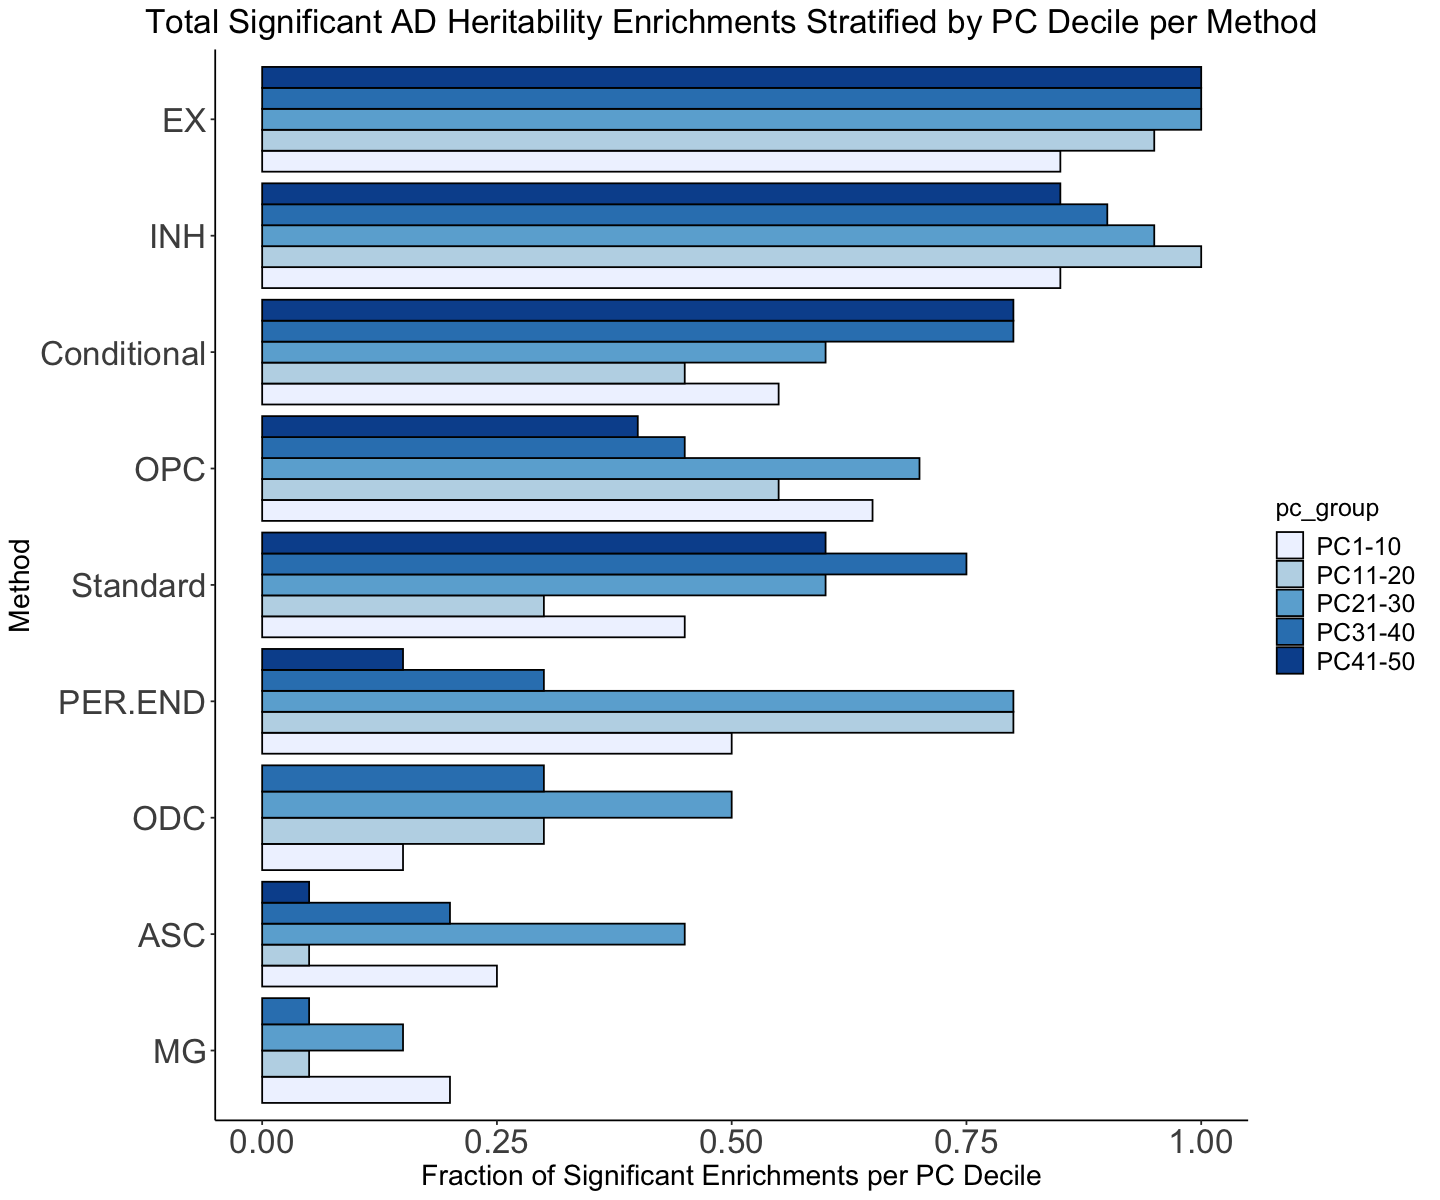

In [133]:
herit_atac = all[all$data_type == "ATAC",]
counts_by_PC_ATAC = herit_atac %>% 
  group_by(method, pc_group) %>% 
  summarise(n = n())
counts_by_PC_ATAC$n = counts_by_PC_ATAC$n / 20 # dividing each decile by total number of possible enrichments
counts_by_PC_ATAC$method = factor(counts_by_PC_ATAC$method, levels = order_method)
ggplot(data=counts_by_PC_ATAC, aes(x=method, y=n, fill=pc_group)) +
  geom_bar(stat="identity",position=position_dodge(),color="black") + 
  scale_fill_brewer(palette="Blues") + coord_flip() + labs(y = "Fraction of Significant Enrichments per PC Decile", x = "Method")+ ggtitle('Total Significant AD Heritability Enrichments Stratified by PC Decile per Method')+ scale_color_discrete(name = "PC Decile")+ theme(axis.text.x=element_text(size=20), axis.text.y=element_text(size=20),text = element_text(size = 15), axis.text = element_text(size = 12),axis.title = element_text(size = 17),plot.title = element_text(hjust = 0.5, size = 20),legend.text=element_text(size=15)) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))
ggsave("enrichments_strat_PC_decile.pdf",width=10, height=10)

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.


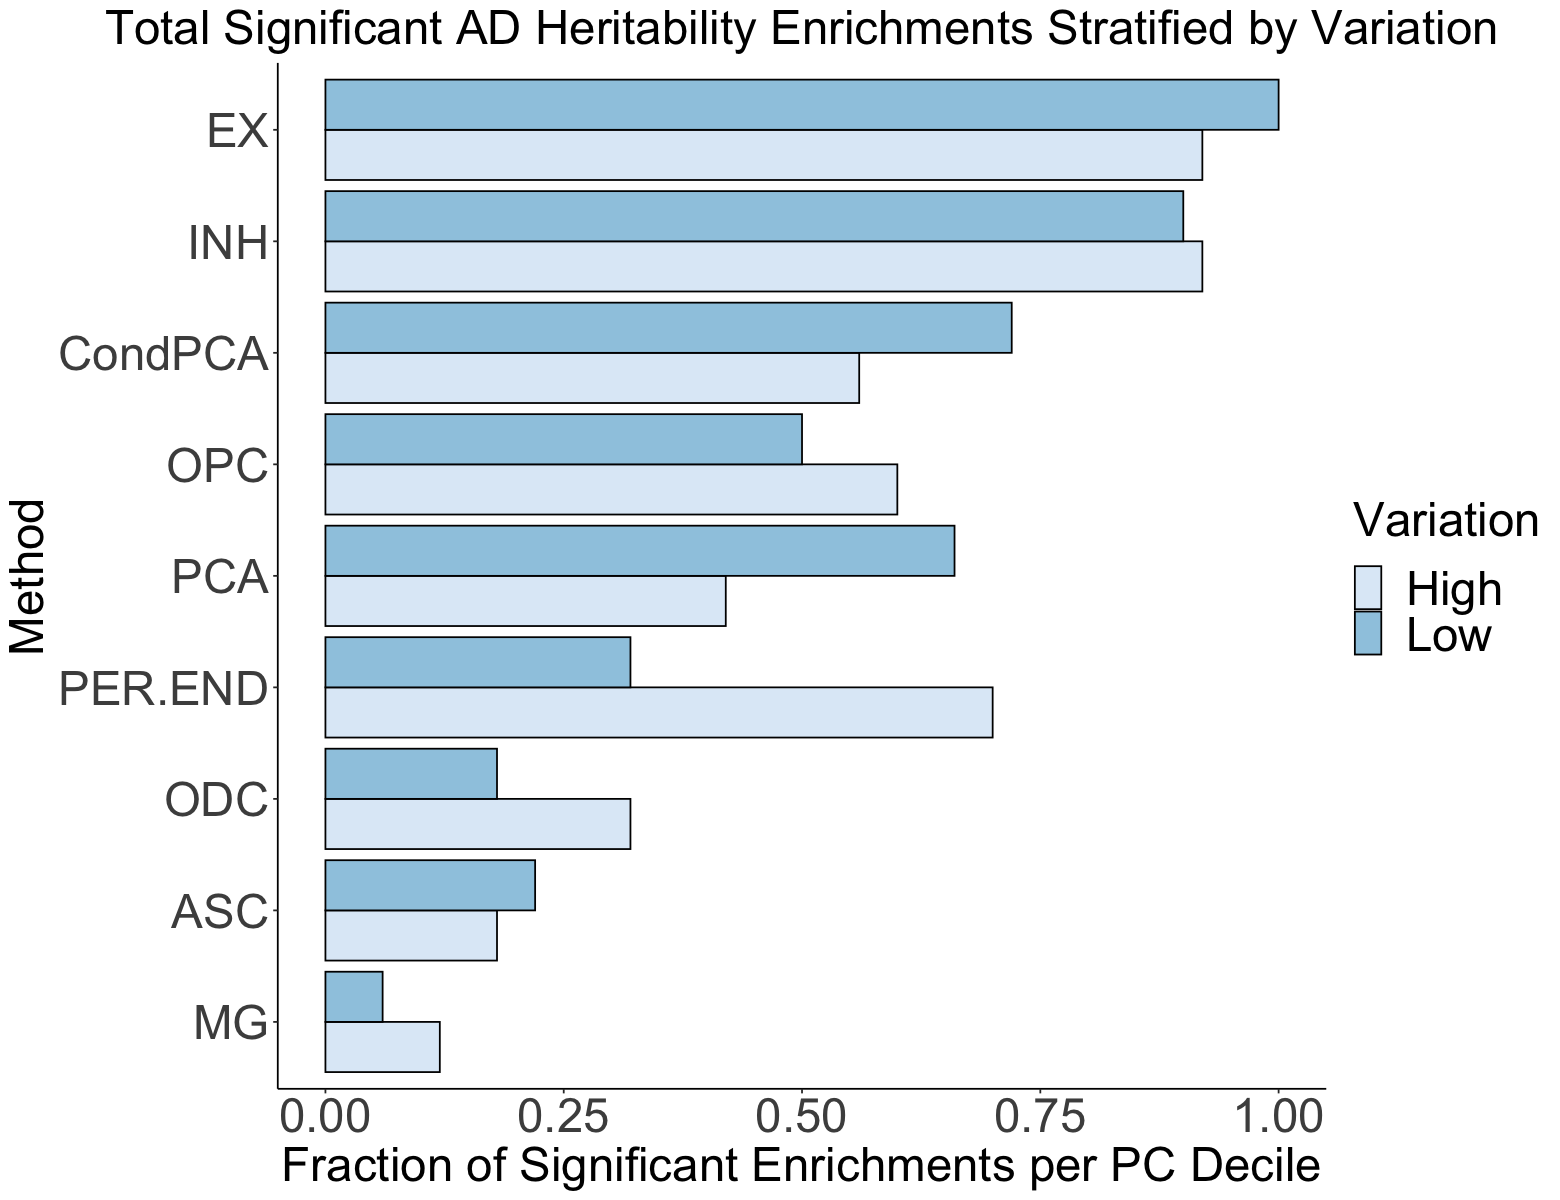

In [177]:
options(repr.plot.width = 13, repr.plot.height = 10)

herit_atac$Variation = NA
herit_atac[herit_atac$PC %in% c(paste0("PC", 1:25)),]$Variation = "High"
herit_atac[herit_atac$PC %in% c(paste0("PC", 26:50)),]$Variation  = "Low"

counts_by_PC_ATAC = herit_atac %>% 
  group_by(method, Variation) %>% 
  summarise(n = n())
  counts_by_PC_ATAC$n = counts_by_PC_ATAC$n / 50 # dividing each decile by total number of possible enrichments

counts_by_PC_ATAC[counts_by_PC_ATAC$method == "Conditional",]$method = "CondPCA"
counts_by_PC_ATAC[counts_by_PC_ATAC$method == "Standard",]$method = "PCA"

size_txt = 28.5
counts_by_PC_ATAC$method = factor(counts_by_PC_ATAC$method, levels = unique(counts_by_PC_ATAC[order(counts_by_PC_ATAC$n),]$method))
ggplot(data=counts_by_PC_ATAC, aes(x=method, y=n, fill=Variation),color="black") +
  geom_bar(stat="identity",position=position_dodge(),color="black") + 
  scale_fill_brewer(palette="Blues") + coord_flip() + labs(y = "Fraction of Significant Enrichments per PC Decile", x = "Method")+ ggtitle('Total Significant AD Heritability Enrichments Stratified by Variation')+ scale_color_discrete(name = "PC Decile")+ theme(axis.text.x=element_text(size=size_txt), axis.text.y=element_text(size=size_txt),text = element_text(size = size_txt), axis.text = element_text(size = size_txt),axis.title = element_text(size = size_txt),plot.title = element_text(hjust = 0.5, size = size_txt),legend.text=element_text(size=size_txt)) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))
#ggsave("enrichments_strat_PC_decile.pdf",width=10, height=10)


In [150]:
order_method

[1] "MG"          "ASC"         "ODC"         "PER.END"     "Standard"   
[6] "OPC"         "Conditional" "INH"         "EX"

[1] "MG"      "ASC"     "ODC"     "PER.END" "PCA"     "OPC"     "CondPCA"
[8] "INH"     "EX"